In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv('./data/BTC-USD.csv')
raw_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-08-21,49327.074219,49717.019531,48312.199219,48905.492188,48905.492188,40585205312
1,2021-08-22,48869.105469,49471.609375,48199.941406,49321.652344,49321.652344,25370975378
2,2021-08-23,49291.675781,50482.078125,49074.605469,49546.148438,49546.148438,34305053719
3,2021-08-24,49562.347656,49878.769531,47687.117188,47706.117188,47706.117188,35361168834
4,2021-08-25,47727.257813,49202.878906,47163.613281,48960.789063,48960.789063,32646349931
...,...,...,...,...,...,...,...
361,2022-08-17,23881.316406,24407.058594,23243.353516,23335.998047,23335.998047,30931623076
362,2022-08-18,23341.039063,23563.832031,23177.601563,23212.738281,23212.738281,23747613147
363,2022-08-19,23213.312500,23213.312500,20868.847656,20877.552734,20877.552734,40509610260
364,2022-08-20,20872.841797,21350.806641,20856.730469,21166.060547,21166.060547,27595671000


In [3]:
# Close price for the last 10 days
seq_data = raw_data[['Close']].to_numpy()
print('Close price for the last 10 days\n', seq_data[0:10])

Close price for the last 10 days
 [[48905.492188]
 [49321.652344]
 [49546.148438]
 [47706.117188]
 [48960.789063]
 [46942.21875 ]
 [49058.667969]
 [48902.402344]
 [48829.832031]
 [47054.984375]]


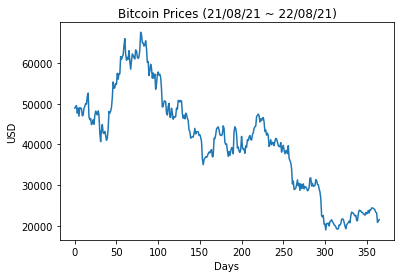

In [4]:
# a year-long change in Bitcoin price
plt.plot(seq_data)
plt.title('Bitcoin Prices (21/08/21 ~ 22/08/21)')
plt.xlabel('Days')
plt.ylabel('USD')
plt.show()

In [5]:
# Set window size

'''
X: window size (days)
horizon: horizon factor

'''

def seq2dataset(seq, window, horizon):
    X = []
    Y = []
    
    for i in range(len(seq) - (window+horizon)+1):
        x = seq[i:(i+window)]
        y = (seq[i+window+horizon-1])
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

In [6]:
w = 7
h = 1
X ,Y = seq2dataset(seq_data, w, h)

print(X.shape, Y.shape)

(359, 7, 1) (359, 1)


In [7]:
# Split dataset
split = int(len(X)*0.7)
x_train = X[0:split]
y_train = Y[0:split]
x_test=X[split:]
y_test=Y[split:]

In [8]:
# Model build
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

In [9]:
model = Sequential()
model.add(Bidirectional(LSTM(units = 128, activation = 'relu', input_shape = x_train[0].shape)))
#model.add(Dropout(0.2))
#model.add(Bidirectional(LSTM(64)))
model.add(Dense(units=4, kernel_initializer='uniform', activation = 'relu'))
model.add(Dense(1))

In [10]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=4)
mc = ModelCheckpoint('Coin_LSTM_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss = 'mae', optimizer = opt, metrics=['mae'])

In [12]:
hist = model.fit(x_train, y_train, epochs = 200, batch_size=1,
                validation_split=0.2)

Epoch 1/200
200/200 [==============================] - 7s 26ms/step - loss: 8856.1094 - mae: 8856.1094 - val_loss: 3821.7993 - val_mae: 3821.7993
Epoch 2/200
200/200 [==============================] - 5s 23ms/step - loss: 2946.7202 - mae: 2946.7202 - val_loss: 1941.7234 - val_mae: 1941.7234
Epoch 3/200
200/200 [==============================] - 5s 26ms/step - loss: 3583.5752 - mae: 3583.5752 - val_loss: 2505.3789 - val_mae: 2505.3789
Epoch 4/200
200/200 [==============================] - 5s 25ms/step - loss: 2451.7322 - mae: 2451.7322 - val_loss: 2217.3533 - val_mae: 2217.3533
Epoch 5/200
200/200 [==============================] - 5s 24ms/step - loss: 2371.7571 - mae: 2371.7571 - val_loss: 1435.5166 - val_mae: 1435.5166
Epoch 6/200
200/200 [==============================] - 6s 28ms/step - loss: 2311.6301 - mae: 2311.6301 - val_loss: 1487.1171 - val_mae: 1487.1171
Epoch 7/200
200/200 [==============================] - 5s 25ms/step - loss: 2155.8264 - mae: 2155.8264 - val_loss: 1541.2892

In [13]:
ev = model.evaluate(x_test, y_test, verbose=0)
print('loss function:', ev[0], "MAE", ev[1])

loss function: 915.7669067382812 MAE 915.7669067382812


In [14]:
pred = model.predict(x_test)
print("MAPE:", sum(abs(y_test-pred)/y_test)/len(x_test))

4/4 [==============================] - 0s 11ms/step
MAPE: [0.03710425]


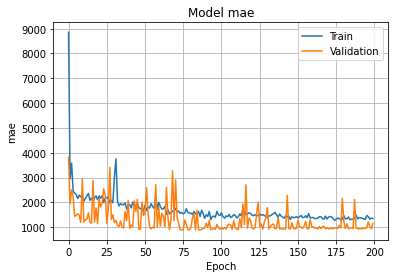

In [15]:
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('Model mae')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'best')
plt.grid()
plt.show()

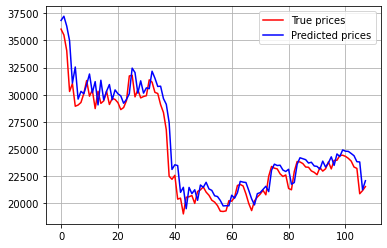

In [16]:
x_range = range(len(y_test))
plt.plot(x_range, y_test[x_range], color = 'red')
plt.plot(x_range, pred[x_range], color = 'blue')
plt.legend(['True prices', 'Predicted prices'], loc = 'best')
plt.grid()
plt.show()